In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.preprocessing import scale # sklearn
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import scipy
from scipy import stats
from IPython.display import display, HTML
import statsmodels.api as sm
import utils as ut # Own functions

In [2]:
# Yearly Electricity Dataset from EMBER: https://ember-climate.org/data/data-catalogue/
data = pd.read_csv('../1_Data/EMBER_yearly_full_release_long_format.csv', encoding='unicode_escape')
green_parties = pd.read_excel('../1_Data/green_parties.xlsx')

In [3]:
data.sample(1)

,Area,Country code,Year,Area type,Continent,Ember region,EU,OECD,G20,G7,ASEAN,Category,Subcategory,Variable,Unit,Value,YoY absolute change,YoY % change
226268,OECD,NaN,2001,Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Power sector emissions,Fuel,Gas,mtCO2,790.54,36.52,4.84


### Manipulate the CI Score

In [6]:
# Since I want to compare select countries to regions that contain them, I need to re-weight the regional CI scores to exclude said countries. 

regions = ['Europe', 'EU', 'G7', 'G20', 'OECD', 'Asia', 'World'] # Look at utils.py's "adapt_country_list" function if you change this. 

for reg in regions:
    country_list = ut.adapt_country_list(reg)
    for i in range(0,23):
        ut.update_CI(data=data, region=reg, country_list=country_list, year=2000+i)
    print('-------------------\n')

Europe --> ['Germany', 'Lithuania']
2000 | Europe CI: 365.8 <-- 382.3
2001 | Europe CI: 362.8 <-- 378.9
2002 | Europe CI: 368.1 <-- 383.6
2003 | Europe CI: 374.9 <-- 389.9
2004 | Europe CI: 364.2 <-- 378.9
2005 | Europe CI: 364.8 <-- 379.0
2006 | Europe CI: 370.9 <-- 383.6
2007 | Europe CI: 371.7 <-- 385.8
2008 | Europe CI: 367.0 <-- 379.1
2009 | Europe CI: 353.4 <-- 366.4
2010 | Europe CI: 346.1 <-- 360.6
2011 | Europe CI: 350.4 <-- 365.2
2012 | Europe CI: 345.2 <-- 361.2
2013 | Europe CI: 329.9 <-- 348.5
2014 | Europe CI: 320.9 <-- 338.7
2015 | Europe CI: 317.5 <-- 334.3
2016 | Europe CI: 313.9 <-- 331.0
2017 | Europe CI: 315.0 <-- 328.8
2018 | Europe CI: 305.5 <-- 318.5
2019 | Europe CI: 291.6 <-- 299.8
2020 | Europe CI: 273.3 <-- 280.1
2021 | Europe CI: 277.3 <-- 287.2
2022 | Europe CI: 285.6 <-- 297.0
-------------------

EU --> ['Germany', 'Lithuania']
2000 | EU CI: 351.5 <-- 382.5
2001 | EU CI: 343.6 <-- 374.8
2002 | EU CI: 356.5 <-- 384.9
2003 | EU CI: 361.2 <-- 389.2
2004 | EU

### Create master file on country level

In [10]:
data_twh_2000 = ut.create_df_twh_by_year(df=data, year=2000)
data_twh_2021 = ut.create_df_twh_by_year(df=data, year=2021)
data_twh_2022 = ut.create_df_twh_by_year(df=data, year=2022)

data_mix_states_2000 = ut.create_df_mix_by_year(df=data, year=2000)
data_mix_states_2021 = ut.create_df_mix_by_year(df=data, year=2021)
data_mix_states_2022 = ut.create_df_mix_by_year(df=data, year=2022)

data_mix_shifts_2000_2021 = ut.create_df_mix_shift_between_years(df=data, year_list=[2000, 2021])
data_mix_shifts_2000_2022 = ut.create_df_mix_shift_between_years(df=data, year_list=[2000, 2022])

data_twh_shifts = ut.create_df_percentage_shift_between_years(df=data, unit='TWh', year_list=[2000, 2021])

data_CI_indices, data_CI_categories = ut.create_df_ci_data(df=data)

data_other_traits = ut.create_df_other_traits(df=data)

In [11]:
data_master = (
    data_twh_2000.copy()
    .merge(data_twh_2021, how="outer", on=['Area'])
    .merge(data_twh_2022, how="outer", on=['Area'])
    .merge(data_mix_states_2000, how="outer", on=['Area'])
    .merge(data_mix_states_2021, how="outer", on=['Area'])
    .merge(data_mix_states_2022, how="outer", on=['Area'])
    .merge(data_twh_shifts, how="outer", on=['Area'])
    .merge(data_mix_shifts_2000_2021, how="outer", on=['Area'])
    .merge(data_mix_shifts_2000_2022, how="outer", on=['Area'])
    .merge(data_CI_indices, how="outer", on=['Area']) #data_CI_categories
    .merge(data_other_traits, how="outer", on=['Area'])
    .merge(green_parties, how="outer", on=['Area'])
)

In [12]:
##############################
# CI index categorization
##############################
conditions = [
    (data_master['CI_index_2021'] <= 0.75),
    (data_master['CI_index_2021'] > 0.75) & (data_master['CI_index_2021'] <= 0.95),
    (data_master['CI_index_2021'] > 0.95) & (data_master['CI_index_2021'] <= 1.05),
    (data_master['CI_index_2021'] > 1.05) & (data_master['CI_index_2021'] < 1.25),
    (data_master['CI_index_2021'] >= 1.25)
]

values = [
    'Major Decrease', 
    'Minor Decrease', 
    'Limited Change', 
    'Minor Increase', 
    'Major Increase'
]

data_master['CI_index_2021_cat'] = np.select(conditions, values)

##############################
# CI score categorization
##############################
q1 = data_master.CI_2021.quantile(0.05)
q2 = data_master.CI_2021.quantile(0.30)
q3 = data_master.CI_2021.quantile(0.70)
q4 = data_master.CI_2021.quantile(0.95)

conditions = [
    (data_master['CI_2021'] <= q1),
    (data_master['CI_2021'] > q1) & (data_master['CI_2021'] <= q2),
    (data_master['CI_2021'] > q2) & (data_master['CI_2021'] <= q3),
    (data_master['CI_2021'] > q3) & (data_master['CI_2021'] <= q4),
    (data_master['CI_2021'] > q4) 
]

values = [
    'Very Low', 
    'Low', 
    'Medium', 
    'High', 
    'Very High'
]

data_master['CI_2021_cat'] = np.select(conditions, values)

q1 = data_master.CI_2000.quantile(0.05)
q2 = data_master.CI_2000.quantile(0.30)
q3 = data_master.CI_2000.quantile(0.70)
q4 = data_master.CI_2000.quantile(0.95)

conditions = [
    (data_master['CI_2000'] <= q1),
    (data_master['CI_2000'] > q1) & (data_master['CI_2000'] <= q2),
    (data_master['CI_2000'] > q2) & (data_master['CI_2000'] <= q3),
    (data_master['CI_2000'] > q3) & (data_master['CI_2000'] <= q4),
    (data_master['CI_2000'] > q4) 
]

values = [
    'Very Low', 
    'Low', 
    'Medium', 
    'High', 
    'Very High'
]

data_master['CI_2000_cat'] = np.select(conditions, values)

##############################
# Nuclear power change categorization
##############################
conditions = [
    (data_master['Nuclear_TWh2000'] == 0) & (data_master['Nuclear_TWh2021'] == 0),
    (data_master['Nuclear_ppmix2000_2021'].isnull()),
    (data_master['Nuclear_ppmix2000_2021'] <= -15),
    (data_master['Nuclear_ppmix2000_2021'] > -15) & (data_master['Nuclear_ppmix2000_2021'] <= -5),
    (data_master['Nuclear_ppmix2000_2021'] > -5) & (data_master['Nuclear_ppmix2000_2021'] <= -2),
    (data_master['Nuclear_ppmix2000_2021'] > -2) & (data_master['Nuclear_ppmix2000_2021'] < 2),
    (data_master['Nuclear_ppmix2000_2021'] >= 2) & (data_master['Nuclear_ppmix2000_2021'] < 5),
    (data_master['Nuclear_ppmix2000_2021'] >= 5) & (data_master['Nuclear_ppmix2000_2021'] < 15),
    (data_master['Nuclear_ppmix2000_2021'] >= 15)
]

values = [
    'Non-Nuclear',
    'Data Unavailable',
    'Major Decrease (-15p or less)', 
    'Moderate Decrease (-5 to -15p)', 
    'Minor Decrease (-5 to -2p)', 
    'Limited Change (±2p)', 
    'Minor Increase (2 to 5p', 
    'Moderate Increase (5 to 15p)', 
    'Major Increase (15p or more)'
]

data_master['nuclear_role_change'] = np.select(conditions, values)

##############################
# Nuclear power current categorization
##############################
conditions = [
    (data_master['Nuclear_%mix2021'] == 0) | (data_master['Nuclear_%mix2021'].isnull()),
    (data_master['Nuclear_%mix2021'] >= 30),
    (data_master['Nuclear_%mix2021'] < 30) & (data_master['Nuclear_%mix2021'] >= 10),
    (data_master['Nuclear_%mix2021'] <10) & (data_master['Nuclear_%mix2021'] > 0)
]

values = [
    'Non-Nuclear',
    'Major Source (30+)',
    'Moderate Source (10-30)', 
    'Minor Source (<10)'
]

data_master['nuclear_size_cat'] = np.select(conditions, values)

In [14]:
filter_nonnuclear_countries_2021 = data_master.query("nuclear_size_cat not in ['Non-Nuclear', 'Data Unavailable']")
filter_nonnuclear_countries_2021 = filter_nonnuclear_countries_2021['Area'].values.tolist()
filter_nonnuclear_countries_2000 = data_master.query('area_type == "Country" & Nuclear_TWh2000 > 0').Area.tolist()

filter_small_countries = data_master.query("Demand_TWh2021 > 1")
filter_small_countries = filter_small_countries['Area'].values.tolist()

In [15]:
all_nuclear_countries = filter_nonnuclear_countries_2021.copy()

for i in filter_nonnuclear_countries_2000:
    if i not in all_nuclear_countries: 
        all_nuclear_countries.append(i)
        
print(all_nuclear_countries)

['Africa', 'Argentina', 'Armenia', 'Asia', 'Belarus', 'Belgium', 'Brazil', 'Bulgaria', 'Canada', 'China', 'Czechia', 'EU', 'Europe', 'Finland', 'France', 'G20', 'G7', 'Germany', 'Hungary', 'India', 'Iran (Islamic Republic of)', 'Japan', 'Latin America and Caribbean', 'Mexico', 'Middle East', 'Netherlands', 'North America', 'OECD', 'Pakistan', 'Romania', 'Russian Federation (the)', 'Slovakia', 'Slovenia', 'South Africa', 'South Korea', 'Spain', 'Sweden', 'Switzerland', 'Taiwan', 'Ukraine', 'United Arab Emirates', 'United Kingdom', 'United States of America', 'World', 'Lithuania']


In [16]:
len(all_nuclear_countries)

45

In [17]:
data_corr_table = ut.create_df_mix_shift_all_years(df=data)

/Users/abtinsalahshor/Documents/abtin-code/nuclear-analysis/2_Script/utils.py:490: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['diffs'][mask] = np.nan


In [18]:
data_corr_table = (
    data_corr_table.merge(data_other_traits, how="left", on=['Area'])
)

In [19]:
data_corr_table.query("Area == @filter_nonnuclear_countries_2021").sample(1)

,Area,Year,Bioenergy_pp_change,Coal_pp_change,Gas_pp_change,Hydro_pp_change,Nuclear_pp_change,Other_Fossil_pp_change,Other_Renewables_pp_change,Wind_and_Solar_pp_change,CI_change,country_code,area_type,Continent,ember_region,EU,OECD,G20,G7,ASEAN
1469,Finland,2016,0.11,2.69,-2.15,-1.46,-0.13,-0.16,0.0,1.09,10.33,FIN,Country,Europe,Europe,1.0,1.0,0.0,0.0,0.0


In [20]:
len(data_master.query('area_type == "Country" & Demand_TWh2000 > 1').CI_2021.unique())

144

# Create visualisations

### How much has nuclear's role changed in nuclear-powered countries?

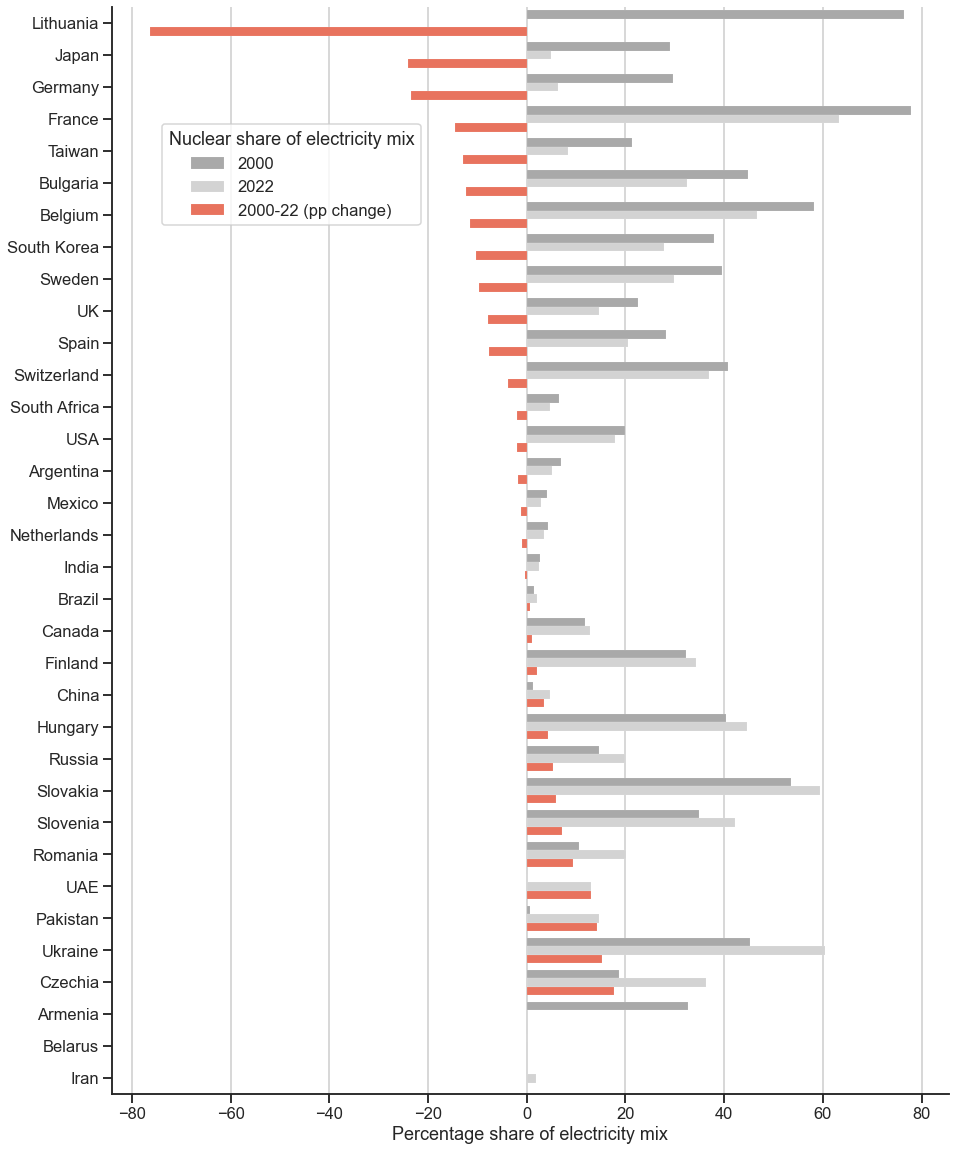

In [34]:
sns.set_context("talk")
sns.set_style("ticks", {'axes.grid' : True})

plt.figure(figsize=(15,20))

country_list = all_nuclear_countries # filter_nonnuclear_countries_2000

data_viz = (
    data_master.copy()
    .query(f"Area in {country_list} & area_type == 'Country'")
    #.query(f"Area != 'Armenia'") 
    .sort_values("Nuclear_ppmix2000_2022", ascending=True)
)

data_viz = (
    data_viz[['Area', 'Nuclear_%mix2000', 'Nuclear_ppmix2000_2022', 'Nuclear_%mix2022', 'ember_region']]
    .rename(columns={
        'Nuclear_%mix2000':'2000',
        'Nuclear_%mix2022':'2022',
        'Nuclear_ppmix2000_2022':'2000-22 (pp change)'
    })
    .melt(id_vars=['Area', 'ember_region'], value_vars=['2000', '2022', '2000-22 (pp change)'])
)

# Rename the most annoying country names
row_names = {'United States of America':'USA',
             'Russian Federation (the)':'Russia',
             'United Arab Emirates':'UAE',
             'United Kingdom':'UK', 
             'Iran (Islamic Republic of)':'Iran'
            }

data_viz = data_viz.replace(row_names)

ax = sns.barplot(data=data_viz, 
                 x="value", 
                 y="Area", 
                 hue='variable',
                 linewidth=0.1,
                 palette=['Darkgrey', 'Lightgrey', 'Tomato'],
                 dodge=True,
                )

sns.despine()
plt.legend(title='Nuclear share of electricity mix', loc='upper left', bbox_to_anchor = (0.05, 0.9))

#plt.suptitle(f"Nuclear-powered countries, 2000-2022")
#plt.title(f"31 countries had nuclear capacity in 2000. Armenia is excluded due to lack of 2022 data.\nData illustrates ")
plt.xlabel(f"Percentage share of electricity mix")
plt.ylabel(f"")


plt.show()

In [35]:
country_list = all_nuclear_countries 

data_viz = (
    data_master.copy()
    .query(f"Area in {country_list} & area_type == 'Country'")
    #.assign(twh_change = lambda x: x['Nuclear_TWh2021'] - x['Nuclear_TWh2000'])
    .sort_values("Nuclear_%TWh2000_2021", ascending=True) # Nuclear_ppmix2000_2022, Nuclear_%TWh2000_2021, twh_change
)

data_viz = (
    data_viz[['Area', 'Nuclear_%TWh2000_2021', 'Green_party_status']]
    .rename(columns={
        'Nuclear_%TWh2000_2021':'TWh change (2000-21)'
    })
    .melt(id_vars=['Area', 'Green_party_status'], value_vars=['TWh change (2000-21)'])
)

data_viz

,Area,Green_party_status,variable,value
0,Lithuania,NaN,TWh change (2000-21),-1.00000
1,Japan,NaN,TWh change (2000-21),-0.80816
2,Germany,In governing coalition,TWh change (2000-21),-0.59242
3,United Kingdom,Represented in national legislature,TWh change (2000-21),-0.46038
4,Taiwan,NaN,TWh change (2000-21),-0.27818
5,Switzerland,Represented in national legislature,TWh change (2000-21),-0.26951
6,Bulgaria,Represented in national legislature,TWh change (2000-21),-0.09296
7,Spain,Represented in national legislature,TWh change (2000-21),-0.09082
8,France,Represented in national legislature,TWh change (2000-21),-0.08623
9,Sweden,Represented in national legislature,TWh change (2000-21),-0.07589


### How has the mix shifted away from nuclear for top decommissioners? 

In [36]:
region_list = filter_nonnuclear_countries_2000
visualisation_list = ['Germany', 'Japan', 'Lithuania']
data_viz = ut.get_region_data(df=data, region_list=region_list, variable="Nuclear", unit="%")

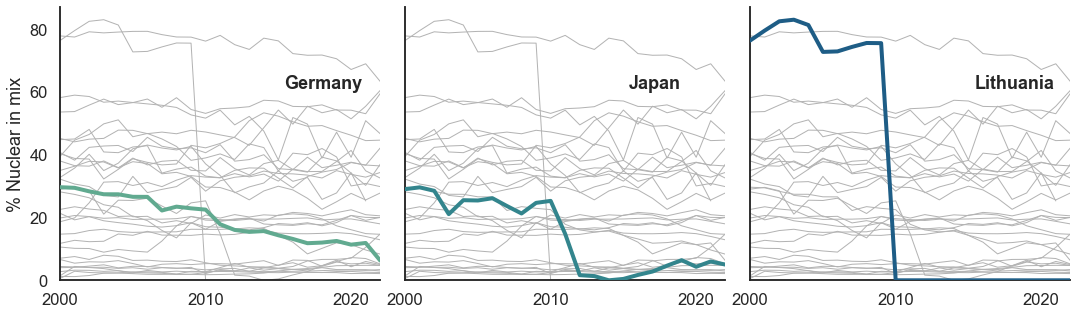

In [37]:
sns.set_context("talk")
sns.set_style("white", {'axes.grid' : False})

# Plot each year's time series in its own facet
fig = sns.relplot(
    data=data_viz.query("Area == @visualisation_list"), # Remove query to get visualisation of all nuclear countries.
    x="Year", y="Value", col="Area", hue="Area",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=3, height=5, aspect=1, legend=False,
)

fig.set(xlim=(2000, 2022))
fig.set(ylim=(0, None))

# Iterate over each subplot to customize further
for area, ax in fig.axes_dict.items():
    
    # Add the title as an annotation within the plot
    ax.text(.7, .7, area, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=data_viz, x="Year", y="Value", units="Area",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
fig.set_titles("")
fig.set_axis_labels("", "% Nuclear in mix")

plt.show()

### How has the total power mix changed for various countries?

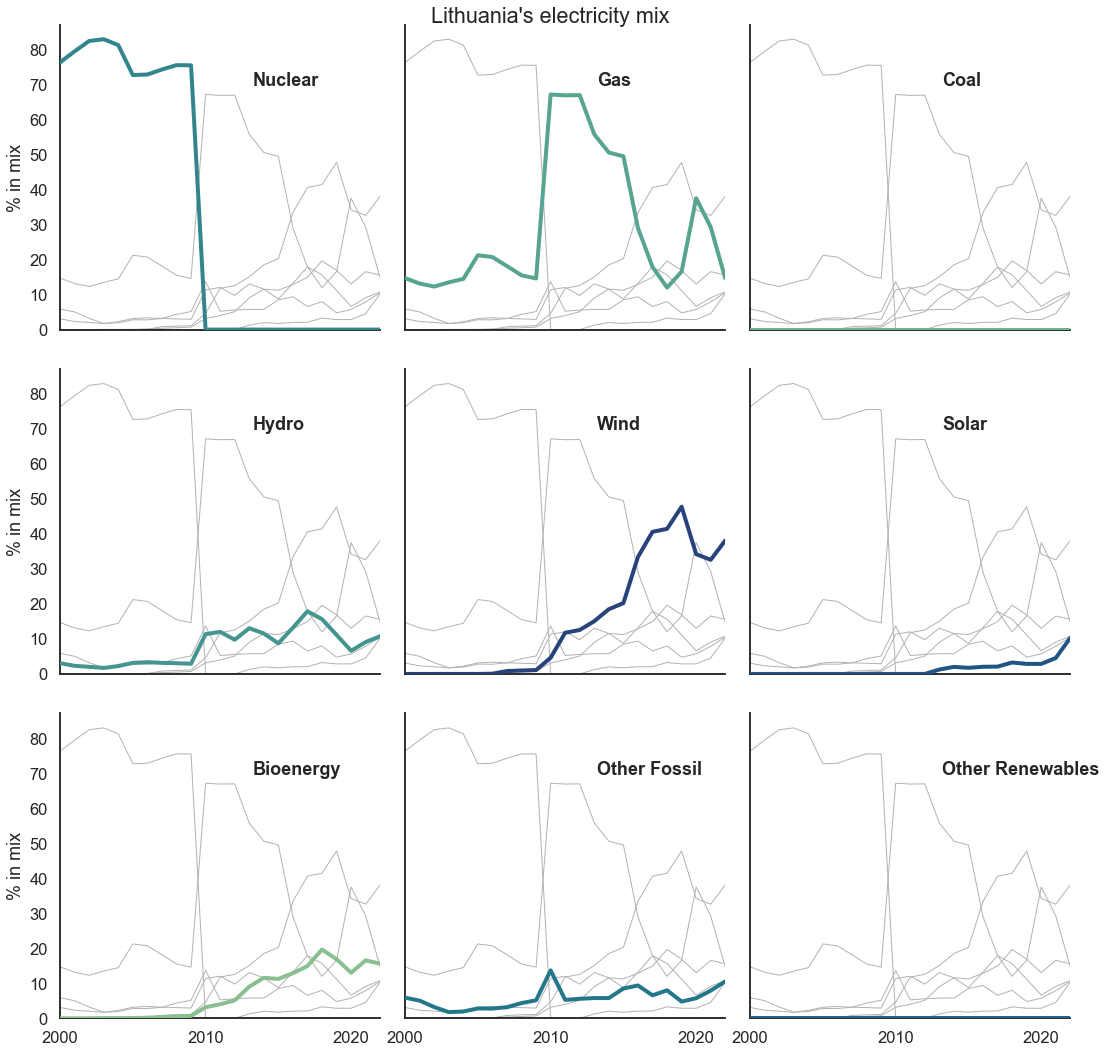

In [38]:
region = 'Lithuania'
unit = '%'

data_viz = (
        data.copy()
        .query(f'Area == "{region}" & Category == "Electricity generation" & Subcategory == "Fuel" & Unit == "{unit}"')
        .reset_index()
    )

data_viz = data_viz[['Year', 'Variable', 'Value']]

sns.set_context("talk")
sns.set_style("white", {'axes.grid' : False})

# Plot each year's time series in its own facet
fig = sns.relplot(
    data=data_viz,
    x="Year", y="Value", col="Variable", hue="Variable",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=3, height=5, aspect=1, legend=False,
    col_order = ['Nuclear', 'Gas', 'Coal', 'Hydro', 'Wind', 'Solar', 'Bioenergy', 'Other Fossil', 'Other Renewables']
)

fig.set(xlim=(2000, 2022))
fig.set(ylim=(0, None))

# Iterate over each subplot to customize further
for variable, ax in fig.axes_dict.items():
    
    # Add the title as an annotation within the plot
    ax.text(.6, 0.8, variable, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=data_viz, x="Year", y="Value", units="Variable",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
fig.fig.suptitle(f"{region}'s electricity mix")
fig.set_titles("")
fig.set_axis_labels("", f"{unit} in mix")

plt.show()

### Shift in CI (pointplot)

In [39]:
def vizualize_CI(CI_type, region_list):
    
    if CI_type=='index':
        drop_type = 'CI_'
        rename_type = 'CI_index_'
        y_label = 'CI index (year 2000 = 1)'
    elif CI_type=='absolute':
        drop_type = 'CI_index_'
        rename_type = 'CI_'
        y_label = 'CI (gCO/kWh)'
    else:
        return(print('Unacceptable CI_type. Select either "index" or "absolute".'))
    
    data_CI_indices, data_CI_categories = ut.create_df_ci_data(df=data)
    
    data_viz = (
        data_CI_indices.copy()
    )
    
    for year in range(2000,2023):
        data_viz = (
            data_viz.drop(columns={f'{drop_type}{year}'}, axis=1)
            .rename(columns={f'{rename_type}{year}':f'{year}'})
        )
        
    data_viz = (
        data_viz.melt(id_vars=['Area'])
        .query('Area == @region_list')
    )
    
    sns.set_context("talk")
    sns.set_style("ticks", {'axes.grid' : True})

    plt.figure(figsize=(15,10))

    ax = sns.pointplot(
        data=data_viz, 
        x="Year", 
        y="value", 
        hue="Area",
        palette="Dark2"    
    )

    sns.despine()
    
    # Add labels to last values
    last_values = data_viz[["Area", "value"]][data_viz["Year"] == '2022']
    for area, value in last_values.itertuples(index=False):
        ax.text(x=22 + 0.4, y=value, s=area, va="center")
    plt.legend([], [], frameon=False)
    
    plt.ylabel(y_label)
    plt.xlabel('Year')
    #plt.suptitle(f'Carbon intensity (CI) in power sector by geography')
    #plt.title(title_label)

    plt.xticks(rotation=45)
    
    plt.show()

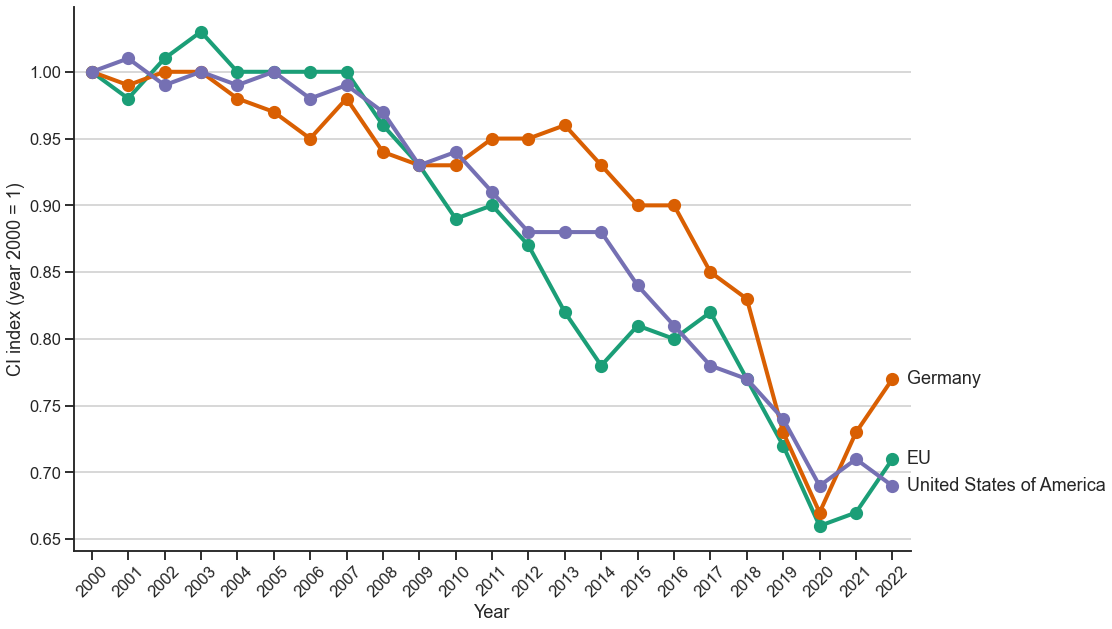

In [40]:
region_list = ['Germany', 'EU', 'United States of America']
vizualize_CI(CI_type='index',region_list=region_list) # CI_type = ['index', 'absolute']

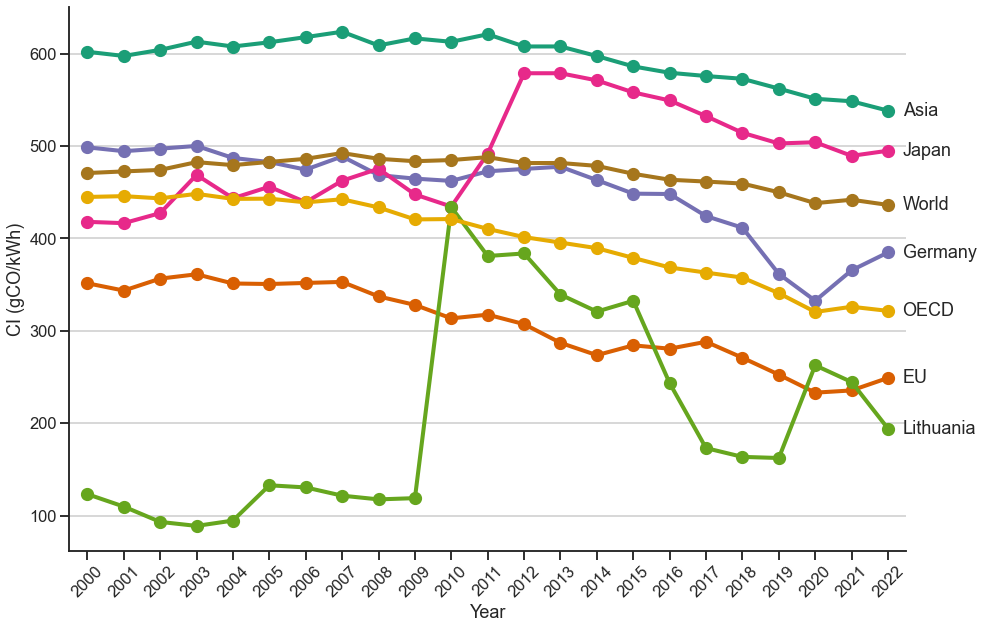

In [41]:
region_list = ['Japan', 'Germany', 'Lithuania', 'OECD', 'World', 'EU', 'Asia'] #
vizualize_CI(CI_type='absolute',region_list=region_list) # CI_type = ['index', 'absolute']

### Shift in CI (scatterplot)

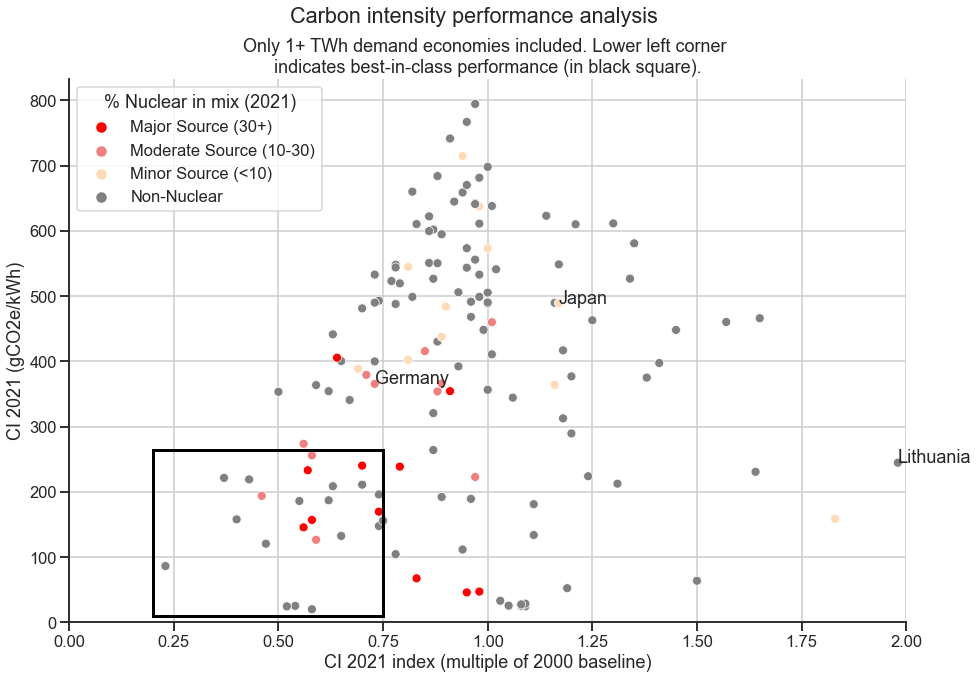

In [42]:
sns.set_context("talk")
sns.set_style("ticks", {'axes.grid' : True})

plt.figure(figsize=(15,10))

df = data_master.copy().query("Demand_TWh2021 > 1 & area_type == 'Country'")

cat_order = [
    'Major Source (30+)', 'Moderate Source (10-30)', 'Minor Source (<10)','Non-Nuclear', 
    #'Major Increase', 'Moderate Increase', 'Minor Increase', 'Limited Change', 'Minor Decrease', 'Moderate Decrease', 'Major Decrease','Non-Nuclear Power','Data Unavailable'
]

ax = sns.scatterplot(
    data=df, 
    x="CI_index_2021", 
    y="CI_2021", 
    hue="nuclear_size_cat", 
    hue_order = cat_order,
    legend=True, 
    palette= ['Red', 'Lightcoral', 'Peachpuff', 'Gray']#"Dark2"
)

sns.despine()

plt.xlim(0, 2)
plt.ylim(0, None)

plt.ylabel(f'CI 2021 (gCO2e/kWh)')
plt.xlabel('CI 2021 index (multiple of 2000 baseline)')
plt.suptitle(f'Carbon intensity performance analysis')
plt.title(f'Only 1+ TWh demand economies included. Lower left corner \nindicates best-in-class performance (in black square).')

y = data_master['CI_2021']
x = data_master['CI_index_2021']
names = data_master['Area']

for i, name in enumerate(names):
    if name in ['Japan', 'Germany', 'Lithuania']:
        ax.annotate(name, (x[i], y[i]))

q1, q2 = (10, data_master['CI_2021'].quantile(0.3))
left, bottom, width, height = (0.2, q1, 0.55, q2-q1)
rect=mpatches.Rectangle((left,bottom),width,height, 
                        fill=False,
                        color="black",
                       linewidth=3,
                       linestyle='-')
                       #facecolor="red")
plt.gca().add_patch(rect)
        
plt.legend(title='% Nuclear in mix (2021)', loc='upper left')

plt.show()

### Analyze top performs (black box in graph above)

In [43]:
top_performers = (
    data_master.copy()
    .query("CI_index_2021_cat == 'Major Decrease' & CI_2021_cat in ('Very Low', 'Low')")
    .query("area_type == 'Country' & Demand_TWh2021 > 1")
)

(top_performers[[
    'Area', 
    'Demand_TWh2021', 
    'CI_2021',
    'Bioenergy_%mix2000',
    'Bioenergy_%mix2021',
    'Wind_and_Solar_%mix2000',
    'Wind_and_Solar_%mix2021',
    'Hydro_%mix2000',
    'Hydro_%mix2021',
    'Nuclear_%mix2000',
    'Nuclear_%mix2021',
    'Other_Renewables_%mix2000',
    'Other_Renewables_%mix2021'
    ]].sort_values(by='Hydro_%mix2000', ascending=False)
)

#print(len(top_performers))

,Area,Demand_TWh2021,CI_2021,Bioenergy_%mix2000,Bioenergy_%mix2021,Wind_and_Solar_%mix2000,Wind_and_Solar_%mix2021,Hydro_%mix2000,Hydro_%mix2021,Nuclear_%mix2000,Nuclear_%mix2021,Other_Renewables_%mix2000,Other_Renewables_%mix2021
117,Lesotho,1.03,20.00,0.00,0.00,0.00,0.00,100.00,100.00,0.00,0.00,0.00,0.00
3,Albania,8.41,23.44,0.00,0.00,0.00,0.78,97.01,99.22,0.00,0.00,0.00,0.00
65,Ethiopia,12.94,25.19,0.59,0.20,0.00,4.42,95.88,95.30,0.00,0.00,0.00,0.00
142,Nepal,8.89,24.51,0.59,0.00,0.00,1.96,95.86,98.04,0.00,0.00,0.00,0.00
58,Ecuador,31.25,155.84,0.00,1.14,0.00,0.31,72.75,79.07,0.00,0.00,0.00,0.00
13,Austria,74.49,147.57,2.56,6.69,0.12,14.22,69.91,57.88,0.00,0.00,0.00,0.00
1,Afghanistan,6.20,120.48,0.00,0.00,0.00,9.64,65.96,74.70,0.00,0.00,0.00,0.00
6,Angola,16.43,195.98,0.00,0.85,0.00,0.12,64.29,69.99,0.00,0.00,0.00,0.00
145,New Zealand,43.42,132.43,1.15,1.08,0.31,6.49,63.32,55.23,0.00,0.00,7.23,18.01
36,Canada,587.88,126.46,1.42,1.44,0.04,6.45,60.32,60.25,11.75,13.96,0.01,0.00


In [44]:
"""
sns.set_context("talk")
sns.set_style("ticks", {'axes.grid' : True})

plt.figure(figsize=(15,10))

df = data_master.copy().query("Demand_TWh2021 > 1 & area_type == 'Country'")

cat_order = [
    'Major Source (30+)', 'Moderate Source (10-30)', 'Minor Source (<10)','Non-Nuclear', 
    #'Major Increase', 'Moderate Increase', 'Minor Increase', 'Limited Change', 'Minor Decrease', 'Moderate Decrease', 'Major Decrease','Non-Nuclear Power','Data Unavailable'
]

ax = sns.scatterplot(
    data=df, 
    x="CI_2021", 
    y="CI_2000", 
    hue="nuclear_size_cat", 
    hue_order = cat_order,
    legend=True, 
    palette= ['Red', 'Lightcoral', 'Peachpuff', 'Gray'] #"Dark2"
)


X_plot = np.linspace(0, 1000, 1000)
Y_plot = X_plot
plt.plot(X_plot, Y_plot, color='Darkgray', linestyle="--")


sns.despine()

plt.xlim(0, None)
plt.ylim(0, None)

plt.ylabel(f'CI 2000 (gCO2e/kWh)')
plt.xlabel('CI 2021 (gCO2e/kWh)')
plt.suptitle(f'Carbon intensity performance analysis')
plt.title(f'Only 1+ TWh demand economies included. Lower left corner indicates best-in-class performance.\nBeing above the dotted line indicates CI improvement from 2000 to 2021.')

y = data_master['CI_2000']
x = data_master['CI_2021']
names = data_master['Area']

for i, name in enumerate(names):
    if name in ['Japan', 'Germany', 'Lithuania']:
        ax.annotate(name, (x[i], y[i]))
        
plt.legend(title='% Nuclear in mix (2021)', loc='upper left')

plt.show()
"""

'\nsns.set_context("talk")\nsns.set_style("ticks", {\'axes.grid\' : True})\n\nplt.figure(figsize=(15,10))\n\ndf = data_master.copy().query("Demand_TWh2021 > 1 & area_type == \'Country\'")\n\ncat_order = [\n    \'Major Source (30+)\', \'Moderate Source (10-30)\', \'Minor Source (<10)\',\'Non-Nuclear\', \n    #\'Major Increase\', \'Moderate Increase\', \'Minor Increase\', \'Limited Change\', \'Minor Decrease\', \'Moderate Decrease\', \'Major Decrease\',\'Non-Nuclear Power\',\'Data Unavailable\'\n]\n\nax = sns.scatterplot(\n    data=df, \n    x="CI_2021", \n    y="CI_2000", \n    hue="nuclear_size_cat", \n    hue_order = cat_order,\n    legend=True, \n    palette= [\'Red\', \'Lightcoral\', \'Peachpuff\', \'Gray\'] #"Dark2"\n)\n\n\nX_plot = np.linspace(0, 1000, 1000)\nY_plot = X_plot\nplt.plot(X_plot, Y_plot, color=\'Darkgray\', linestyle="--")\n\n\nsns.despine()\n\nplt.xlim(0, None)\nplt.ylim(0, None)\n\nplt.ylabel(f\'CI 2000 (gCO2e/kWh)\')\nplt.xlabel(\'CI 2021 (gCO2e/kWh)\')\nplt.suptit

In [45]:
"""
sns.set_context("talk")
sns.set_style("ticks", {'axes.grid' : True})

plt.figure(figsize=(15,10))

df = (
    data_master.copy()
    .query("Area == @filter_nonnuclear_countries_2000")
    .reset_index()
    .drop(columns={'index'})
    .rename(columns={'Demand_TWh2021':'var'}).query("var > 1")
)

cat_order = [
    'Major Increase (15p or more)', 
    'Moderate Increase (5 to 15p)',  
    'Minor Increase (2 to 5p)',  
    'Limited Change (±2p)',  
    'Minor Decrease (-5 to -2p)',
    'Moderate Decrease (-5 to -15p)', 
    'Major Decrease (-15p or less)'
]

ax = sns.swarmplot(data=df, 
                   x="CI_index_2021", 
                   y="nuclear_role_change",
                   order=cat_order,
                   size=10,
                   palette="Dark2"
           )

sns.despine()

n_value = []
n_value = []
for i in cat_order:
    val = (
        df.copy()
        .query(f'nuclear_role_change == "{i}"')
        .reset_index()
        .count()[0]
    )
    n_value.append(val)
    
max_value = max(df['CI_index_2021'])
separator=' '

plt.xlim(0, max_value+0.4)

for i in range(len(n_value)):
    ax.annotate(separator.join(['n:', str(n_value[i])]), 
                xy = (max_value+0.3, i))

x = df['CI_index_2021']
names = df['Area']

for i, name in enumerate(names):
    if name in ['Japan', 'Germany', 'Lithuania']:
        ax.annotate(name, 
                    xy = (x[i]+0.03, 6))
    
plt.ylabel(f"Percentage point change in nuclear's share of electricity mix")
plt.xlabel(f"2021 CI index (2000 = 1)")
plt.suptitle(f"CI change in relation to nuclear's changing role")
plt.title(f'Excludes countries without nuclear fleets in 2021 or where data is unavailable.')

plt.show()
"""

'\nsns.set_context("talk")\nsns.set_style("ticks", {\'axes.grid\' : True})\n\nplt.figure(figsize=(15,10))\n\ndf = (\n    data_master.copy()\n    .query("Area == @filter_nonnuclear_countries_2000")\n    .reset_index()\n    .drop(columns={\'index\'})\n    .rename(columns={\'Demand_TWh2021\':\'var\'}).query("var > 1")\n)\n\ncat_order = [\n    \'Major Increase (15p or more)\', \n    \'Moderate Increase (5 to 15p)\',  \n    \'Minor Increase (2 to 5p)\',  \n    \'Limited Change (±2p)\',  \n    \'Minor Decrease (-5 to -2p)\',\n    \'Moderate Decrease (-5 to -15p)\', \n    \'Major Decrease (-15p or less)\'\n]\n\nax = sns.swarmplot(data=df, \n                   x="CI_index_2021", \n                   y="nuclear_role_change",\n                   order=cat_order,\n                   size=10,\n                   palette="Dark2"\n           )\n\nsns.despine()\n\nn_value = []\nn_value = []\nfor i in cat_order:\n    val = (\n        df.copy()\n        .query(f\'nuclear_role_change == "{i}"\')\n      

### Correlation tables

In [46]:
corr_table = (
    data_corr_table.copy()
    #.query("EU == 1.0")
    #.query("Area == 'Germany'")
    .query("Area == @filter_nonnuclear_countries_2000")
    #.query("Area == @top_performers")
    .query("Area == @filter_small_countries")
    .drop(columns=['OECD', 'EU', 'G20', 'G7', 'ASEAN', 'area_type', 'Continent', 'ember_region', 'country_code', 'Year'])
    .rename(columns={
        'Bioenergy_pp_change':'Bioenergy',
        'Coal_pp_change':'Coal',
        'Gas_pp_change':'Gas',
        'Hydro_pp_change':'Hydro',
        'Nuclear_pp_change':'Nuclear',
        'Other_Fossil_pp_change':'Other Fossil',
        'Other_Renewables_pp_change':'Other Renewables',
        'Wind_and_Solar_pp_change':'Wind and Solar',
        'CI_change':'CI'
    })
)
corr_table.sample(5)

,Area,Bioenergy,Coal,Gas,Hydro,Nuclear,Other Fossil,Other Renewables,Wind and Solar,CI
574,Brazil,0.11,-0.54,1.33,-2.84,-0.06,0.46,0.00,1.55,5.07
1960,Hungary,0.65,-0.39,-1.17,0.02,0.22,0.13,0.03,0.50,-5.79
4123,Sweden,-0.24,0.00,0.00,-2.74,-1.01,0.00,0.00,3.97,-0.74
1480,France,0.00,-0.39,0.25,-0.01,0.26,-0.14,-0.01,0.03,-2.92
4180,Taiwan,-0.01,-0.22,1.08,-0.12,-0.16,-0.76,0.00,0.19,-1.76


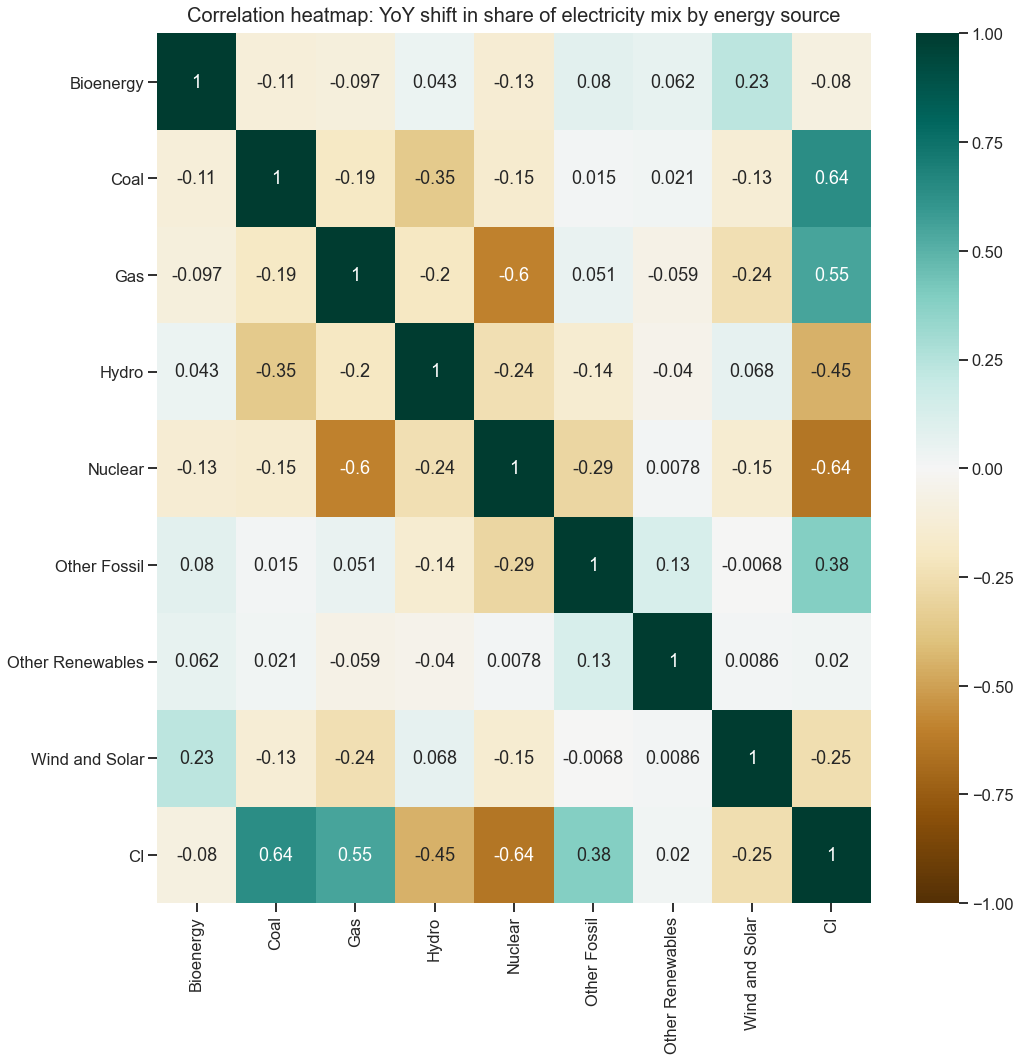

In [49]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 16))

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(corr_table.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG') # mask = mask

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation heatmap: YoY shift in share of electricity mix by energy source', fontdict={'fontsize':20}, pad=12);

In [50]:
basic_corr_table = corr_table.corr()[['CI']].sort_values(by='CI', ascending=False)
basic_corr_table = basic_corr_table[basic_corr_table.CI != 1]
basic_corr_table

,CI
Coal,0.640260
Gas,0.550751
Other Fossil,0.383968
Other Renewables,0.019819
Bioenergy,-0.080156
Wind and Solar,-0.252414
Hydro,-0.445527
Nuclear,-0.643658


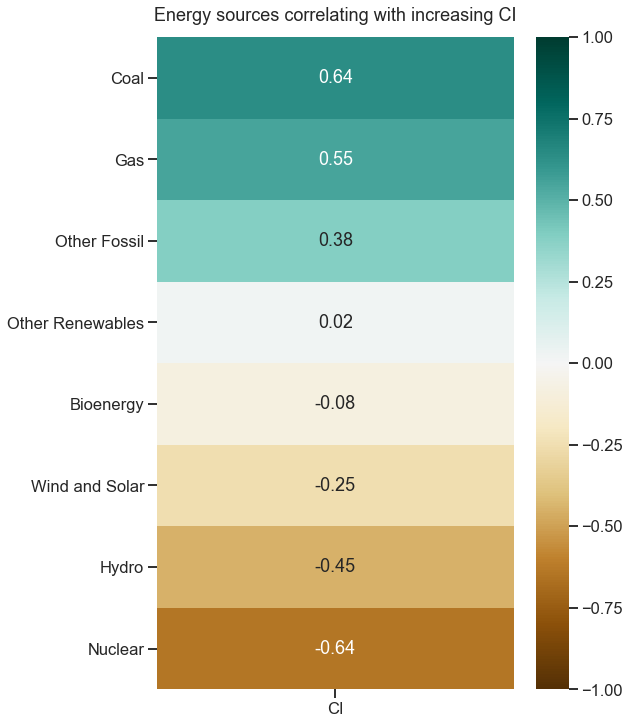

In [51]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(basic_corr_table, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Energy sources correlating with increasing CI', fontdict={'fontsize':18}, pad=16);


In [52]:
"""
sns.set_theme(style="ticks")


sns.set_context("talk")
sns.set_style("ticks", {'axes.grid' : True})

plt.figure(figsize=(15,15))

ax = sns.pairplot(corr_table)

sns.despine()

plt.show()
"""

'\nsns.set_theme(style="ticks")\n\n\nsns.set_context("talk")\nsns.set_style("ticks", {\'axes.grid\' : True})\n\nplt.figure(figsize=(15,15))\n\nax = sns.pairplot(corr_table)\n\nsns.despine()\n\nplt.show()\n'

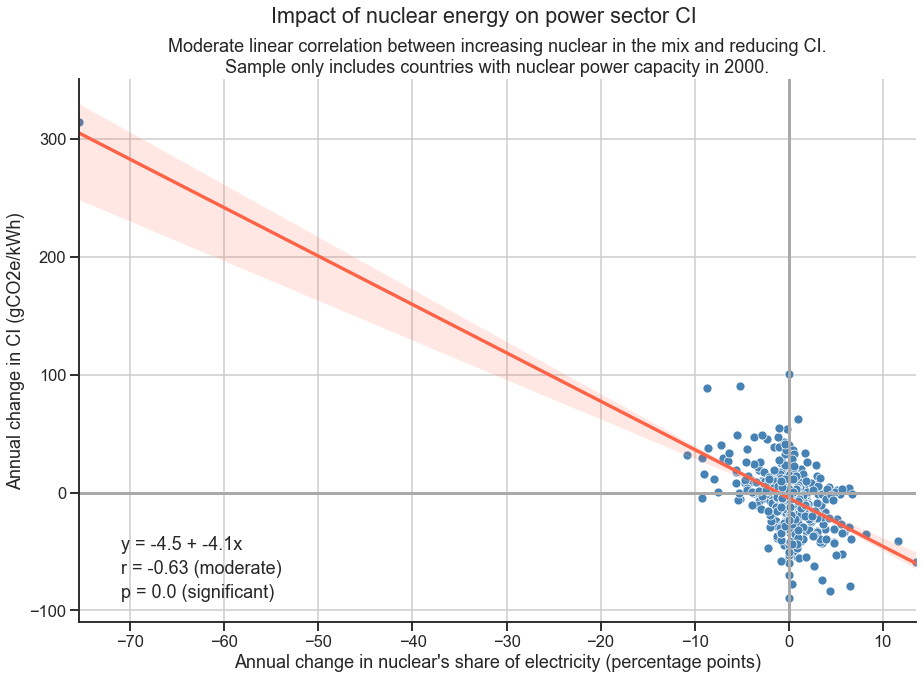

In [53]:
sns.set_context("talk")
sns.set_style("ticks", {'axes.grid' : True})

plt.figure(figsize=(15,10))

corr_table = corr_table.dropna()

ax = sns.scatterplot(
    data=corr_table, 
    x="Nuclear", 
    y="CI", 
    legend=True, 
    color= "steelblue"
)

sns.regplot(data=corr_table, x="Nuclear", y="CI", scatter=False, ax=ax, color='tomato')

res = scipy.stats.linregress(x=corr_table['Nuclear'],
                             y=corr_table['CI'])

sns.despine()

ax.axhline(0, color='darkgrey', linewidth=3)
ax.axvline(0, color='darkgrey', linewidth=3)

plt.ylabel(f'Annual change in CI (gCO2e/kWh)')
plt.xlabel("Annual change in nuclear's share of electricity (percentage points)")
plt.suptitle(f'Impact of nuclear energy on power sector CI')
plt.title(f'Moderate linear correlation between increasing nuclear in the mix and reducing CI.\nSample only includes countries with nuclear power capacity in 2000.')


x_min = min(corr_table['Nuclear'])
x_max = max(corr_table['Nuclear'])
y_min = min(corr_table['CI'])
y_max = max(corr_table['CI'])

x_pos = x_min + 0.05 * (x_max-x_min)
y_pos = y_min + 0.1 * (y_max-y_min)

ax.text(x_pos, y_pos, 'y = ' + str(round(res.intercept,2)) + ' + ' + str(round(res.slope,2)) + 'x')
ax.text(x_pos, y_pos-20, 'r = ' + str(round(res.rvalue,2)) + ' (moderate)')
ax.text(x_pos, y_pos-40, 'p = ' + str(round(res.pvalue,5)) + ' (significant)')

plt.show()

In [54]:
res

LinregressResult(slope=-4.101010770440736, intercept=-4.497384760994822, rvalue=-0.6349891008615046, pvalue=2.1409111250679037e-70, stderr=0.20200869758648737, intercept_stderr=0.7826236301319547)

In [55]:
corr_table

,Area,Bioenergy,Coal,Gas,Hydro,Nuclear,Other Fossil,Other Renewables,Wind and Solar,CI
133,Argentina,-0.03,-0.49,-7.11,8.95,0.53,-1.87,0.00,0.01,-49.64
134,Argentina,0.23,-0.53,0.42,1.36,-0.92,-0.58,0.00,0.03,-5.77
135,Argentina,0.32,0.06,3.91,-5.76,1.34,0.12,0.00,0.00,20.05
136,Argentina,-0.08,0.65,3.35,-6.48,-0.34,2.91,0.00,-0.02,40.48
137,Argentina,-0.01,0.38,-2.31,1.88,-1.32,1.37,0.00,0.01,1.77
...,...,...,...,...,...,...,...,...,...,...
4543,United States of America,-0.08,-2.40,2.98,-0.43,-0.65,0.08,-0.03,0.52,-4.73
4544,United States of America,-0.09,-4.15,3.17,-0.02,0.25,-0.12,-0.01,0.98,-19.28
4545,United States of America,-0.03,-4.08,2.03,0.12,0.08,-0.05,0.02,1.90,-23.39
4546,United States of America,-0.04,2.49,-2.15,-0.99,-0.77,0.00,-0.01,1.48,9.87


In [56]:
# Calculate Cook's Distance

# Define explanatory and response variables
x, y = corr_table['Nuclear'], corr_table['CI']

# Add constant to predictor variables
x = sm.add_constant(x)

# Fit linear regression model
model = sm.OLS(y, x).fit() 

# Suppress scientific notation
np.set_printoptions(suppress=True)

# Create instance of influence
influence = model.get_influence()

# Obtain Cook's distance for each observation
cooks = influence.cooks_distance

# Count number of observations
n_obs = len(x)

# If CD > 4/n_obs, a point is considered to be influential
z = 4/n_obs

# Create dataframe
cd_table = pd.DataFrame(
    {
        "Area": corr_table['Area'],
        "Nuclear": corr_table['Nuclear'],
        "CI": corr_table['CI'],
        "Cooks_distance": cooks[0],
        "CD_p_value": cooks[1]
    }
)

cd_table = (
    cd_table.assign(influential= lambda x: x['Cooks_distance'].apply(lambda y: "No" if y < z else "Yes"))
)

influential_obs = cd_table.query('influential == "Yes"')

# Display Cook's distances
#print(cooks[1])

#plt.scatter(corr_table['Nuclear'], cooks[0])
#plt.xlabel('x')
#plt.ylabel('Cooks Distance')
#plt.show()

print(f"The limit for an influential point is a Cook's Distance value of {round(z,5)}")

print(f"\nOut of {n_obs} datapoints, {len(influential_obs)} are considered influential:\n")

influential_obs.sort_values('Cooks_distance', ascending=False)

The limit for an influential point is a Cook's Distance value of 0.00654

Out of 612 datapoints, 22 are considered influential:



,Area,Nuclear,CI,Cooks_distance,CD_p_value,influential
2514,Lithuania,-75.50,314.68,0.525757,0.591375,Yes
609,Bulgaria,-8.72,88.51,0.042737,0.958167,Yes
1459,Finland,-5.17,90.11,0.031512,0.968981,Yes
2524,Lithuania,0.00,100.27,0.024123,0.976166,Yes
1458,Finland,6.55,-79.65,0.020853,0.979364,Yes
4121,Sweden,-9.22,-4.66,0.020728,0.979486,Yes
157,Armenia,4.39,-83.43,0.019655,0.980538,Yes
2520,Lithuania,0.00,-89.10,0.015731,0.984393,Yes
3903,Slovenia,3.60,-74.27,0.013055,0.987030,Yes
3904,Slovenia,1.04,62.39,0.012233,0.987842,Yes


### Renewables growth (barplot)

In [58]:
def get_region_data_point(df, region, variable, unit, year):
    
    value = (
        df.copy()
        .query(f'Area == "{region}" & Variable == "{variable}" & Unit == "{unit}" & Year == {year}')
        .reset_index()
        .aggregate({'Value':'sum'})
        ._get_value(0, 'Value')
    )
    
    return value

In [59]:
def compare_regions(data, reg1, reg2, variable, unit, year1, year2):
    
    reg1_year1 = get_region_data_point(df=data, region=reg1, variable=variable, unit=unit, year=year1)
    reg1_year2 = get_region_data_point(df=data, region=reg1, variable=variable, unit=unit, year=year2)
    reg2_year1 = get_region_data_point(df=data, region=reg2, variable=variable, unit=unit, year=year1)
    reg2_year2 = get_region_data_point(df=data, region=reg2, variable=variable, unit=unit, year=year2)
    
    print('--------------------------------------')
    
    print(f'{reg1}|{year1}: {reg1_year1.round()}')
    print(f'{reg1}|{year2}: {reg1_year2.round()}')
    
    print('\n')
    
    print(f'{reg2}|{year1}: {reg2_year1.round()}')
    print(f'{reg2}|{year2}: {reg2_year2.round()}')
    
    print('\n')
    
    print(f'{reg1}|{year1}-{year2}: {round(reg1_year2/reg1_year1-1, 2)}')
    print(f'{reg2}|{year1}-{year2}: {round(reg2_year2/reg2_year1-1, 2)}')
    
    print('\n')
    
    print(f'{reg1} vs {reg2}|{year1}: {round(reg1_year1/reg2_year1-1, 2)}')
    print(f'{reg1} vs {reg2}|{year2}: {round(reg1_year2/reg2_year2-1, 2)}')
    
    print('--------------------------------------')

In [235]:
compare_regions(data=data, reg1="Japan", reg2="Germany", variable="Total Generation", unit="TWh", year1=2001, year2=2011)

--------------------------------------
Japan|2001: 1083.0
Japan|2011: 1104.0


Germany|2001: 582.0
Germany|2011: 605.0


Japan|2001-2011: 0.02
Germany|2001-2011: 0.04


Japan vs Germany|2001: 0.86
Japan vs Germany|2011: 0.82
--------------------------------------


In [61]:
data.Variable.unique()

array(['Clean', 'Fossil', 'Gas and Other Fossil',
       'Hydro, Bioenergy and Other Renewables', 'Renewables',
       'Wind and Solar', 'Bioenergy', 'Coal', 'Gas', 'Hydro', 'Nuclear',
       'Other Fossil', 'Other Renewables', 'Solar', 'Wind', 'Demand',
       'Demand per capita', 'Total Generation', 'Net Imports',
       'CO2 intensity', 'Total emissions'], dtype=object)

In [62]:
compare_regions(data=data, reg1="Denmark", reg2="Germany", variable="Wind and Solar", unit="TWh", year1=2000, year2=2022)

--------------------------------------
Denmark|2000: 4.0
Denmark|2022: 21.0


Germany|2000: 9.0
Germany|2022: 185.0


Denmark|2000-2022: 3.94
Germany|2000-2022: 18.67


Denmark vs Germany|2000: -0.55
Denmark vs Germany|2022: -0.89
--------------------------------------


In [63]:
compare_regions(data=data, reg1="Germany", reg2="Lithuania", variable="Net Imports", unit="TWh", year1=2000, year2=2000)

--------------------------------------
Germany|2000: 3.0
Germany|2000: 3.0


Lithuania|2000: -1.0
Lithuania|2000: -1.0


Germany|2000-2000: 0.0
Lithuania|2000-2000: 0.0


Germany vs Lithuania|2000: -3.28
Germany vs Lithuania|2000: -3.28
--------------------------------------


# DATA MODEL

I will design three models to predict the carbon cost of nuclear decommissioning. 

### Model 1 - Baseline replacement: 
* Based on replacement CO2 cost of each TWh nuclear. 
* Assumes that year 2000 is the STATIC nuclear generation over next 20 years unless politically tampered with - call it [TWh nuclear baseline].  
* For each 1 TWh nuclear lost from baseline, looks at what else has replaced it. 
* Calculate the difference between [Nuclear CI] and the ["Replacement mix" CI] - call the [CI diff].  
* [MtCO2 avoidable emissions from keeping baseline] = [CI diff] x [TWh nuclear replaced]. 
* Assumes IPCC 2015 CIs (same as Ember's assumption). 
* [CI diff] = [Coal % of replacement] x [Coal CI] + ... + [Solar % of replacement] x [Solar CI]
* [Energy source % of replacement] = [Coal % of total added generation] x [2000 generation % of current-year generation]
* [2000 generation % of current-year generation] - only added if [current-year generation] > [2000 generation]
* Neglects increases in demand - any demand increase would have to have been served by something other than nuclear, since we assume that it will not move beyond the baseline.

### Model 2 - Worst emitter replacement without intermittent renewables:
* Assumes that year 2000 is the STATIC nuclear generation over next 20 years unless politically tampered with - call it [TWh nuclear baseline].
* Assumes no growth in intermittent renewables from year 2000 (wind, solar)
* For each 1 TWh nuclear lost from baseline, looks at how many TWh of worst-emitters (descending order: coal, other fossils, gas) that nuclear could eliminate until demand threshold is reached.
* Calculate difference between [TWh demand] and [TWh total generation] per year, assuming nuclear baseline. 
* If [TWh diff] = [TWh total generation] - [TWh demand] > 0, take out [TWh diff] TWh of worst emitting sources out of the system.
* [MtCO2 avoidable emissions from replacing worst-emitters] = [CI worst-emitter] x [TWh worst-emitter replaced].
* [TWh total generation] = [TWh actual total generation] + [TWh nuclear replaced] - [TWh solar and wind added]

### Model 3 - Worst emitter replacement with intermittent renewables:
* Same as Model 2 except intermittent renewables kept in [TWh total generation]
* [TWh total generation] = [TWh actual total generation] + [TWh nuclear replaced]

Easiest: calculate total emission for all three models plus reality. Compare these four values against each other to get the potential avoided emissions between different scenarios.

In [223]:
def return_CI_by_source(source):
    
    # CI data from Ember. Based on IPCC 2015. https://ember-climate.org/app/uploads/2022/03/GER22-Methodology.pdf
    CI_table = [
        ['Coal', 820], 
        ['Gas', 490], 
        ['Other Fossil', 700],
        ['Wind', 11],
        ['Solar', 48],
        ['Bioenergy', 230],
        ['Hydro', 24],
        ['Other Renewables', 38], # Based on IPCC's geothermal
        ['Nuclear', 12]
    ]
    
    # Turn into Dataframe
    CI_table = pd.DataFrame(CI_table, columns=['Source', 'CI_IPCC'])
    
    # Extract value based on "source" input. 
    CI_value = (
        CI_table.copy()
        .query(f"Source == '{source}'")
        .reset_index()
        .aggregate({'CI_IPCC':'sum'})
        ._get_value(0, 'CI_IPCC')
    )
    
    return(CI_value)

In [224]:
return_CI_by_source('Nuclear')

12

In [225]:
def get_emissions_S1(df, region, year):
    
    var1, unit1 = ('Total Generation', 'TWh')
    var2, unit2 = ('CO2 intensity', 'gCO2/kWh')
    
    twh = get_region_data_point(df=df, region=region, variable=var1, unit=unit1, year=year)
    CI = get_region_data_point(df=df, region=region, variable=var2, unit=unit2, year=year)
    
    # TWh x gCO2/kWh = ktCO2. Divided by 1 000 000 yield GtCO2
    gtCO2_S1 = twh * CI / 1000000
    
    # Get how much nuclear needs to produce in this scenario
    nuclear_needed = get_region_data_point(df=df, region=region, variable='Nuclear', unit='TWh', year=year)
    
    # 
    nuclear_deficit = 0
    
    return(gtCO2_S1, nuclear_needed, nuclear_deficit)

In [226]:
def get_emissions_S2(df, region, current_year, baseline_year):
    
    # Get current TWh generation
    generation_current = get_region_data_point(df=df, region=region, variable='Total Generation', unit='TWh', year=current_year)
        
    # Get baseline CI
    CI_baseline = get_region_data_point(df=df, region=region, variable='CO2 intensity', unit='gCO2/kWh', year=baseline_year)
    
    # Calculate current emissions with baseline CI 
    gtCO2_S2 = generation_current * CI_baseline / 1000000 # TWh x gCO2/kWh = ktCO2. Divided by 1 000 000 yield GtCO2
    
    # Calculate necessary growth in nuclear generation
    nuclear_generation_baseline = get_region_data_point(df=df, region=region, variable='Nuclear', unit='TWh', year=baseline_year)
    nuclear_generation_share = get_region_data_point(df=df, region=region, variable='Nuclear', unit='%', year=baseline_year) / 100 # Percentage
    nuclear_generation_current = generation_current * nuclear_generation_share
    nuclear_deficit = nuclear_generation_current - nuclear_generation_baseline
    if nuclear_deficit < 0:
        nuclear_deficit = 0    
        
    # Get how much nuclear needs to produce in this scenario
    nuclear_needed = nuclear_generation_current
    
    return(gtCO2_S2, nuclear_needed, nuclear_deficit)

In [236]:
def get_emissions_S345(df, region, current_year, baseline_year, res_growth_reduction): #no_renewables
    
    # Get current TWh generation
    generation_current = get_region_data_point(df=df, region=region, variable='Total Generation', unit='TWh', year=current_year)
        
    # Get current TWh demand
    demand_current = get_region_data_point(df=df, region=region, variable='Demand', unit='TWh', year=current_year)
    
    
    # Get baseline and current renewables TWh
    wind_generation_baseline = get_region_data_point(df=df, region=region, variable='Wind', unit='TWh', year=baseline_year)
    wind_generation_current = get_region_data_point(df=df, region=region, variable='Wind', unit='TWh', year=current_year)
    solar_generation_baseline = get_region_data_point(df=df, region=region, variable='Solar', unit='TWh', year=baseline_year)
    solar_generation_current = get_region_data_point(df=df, region=region, variable='Solar', unit='TWh', year=current_year)

    # Get growth and adjust generation
    wind_growth = wind_generation_current - wind_generation_baseline
    solar_growth = solar_generation_current - solar_generation_baseline
    
    
    # Adjust amount of RES in model
    wind_growth = wind_growth * res_growth_reduction # res_growth_reduction: 0 = S1 scenario pace, 0.2 = 20% less than S1, 0.4 = 40% less than S1, ... 
    solar_growth = solar_growth * res_growth_reduction
    ws_emissions = wind_growth * return_CI_by_source('Wind') + solar_growth * return_CI_by_source('Solar')
    
    '''
    if no_renewables:
        
        # Get baseline and current renewables TWh
        wind_generation_baseline = get_region_data_point(df=df, region=region, variable='Wind', unit='TWh', year=baseline_year)
        wind_generation_current = get_region_data_point(df=df, region=region, variable='Wind', unit='TWh', year=current_year)
        solar_generation_baseline = get_region_data_point(df=df, region=region, variable='Solar', unit='TWh', year=baseline_year)
        solar_generation_current = get_region_data_point(df=df, region=region, variable='Solar', unit='TWh', year=current_year)
        
        # Get growth and adjust generation
        wind_growth = wind_generation_current - wind_generation_baseline
        solar_growth = solar_generation_current - solar_generation_baseline
        ws_emissions = wind_growth * return_CI_by_source('Wind') + solar_growth * return_CI_by_source('Solar')
        #generation_current = generation_current - wind_growth - solar_growth
        
    else:
        wind_growth = 0
        solar_growth = 0
        ws_emissions = 0
    '''
    
    # Get baseline and current nuclear TWh
    nuclear_generation_baseline = get_region_data_point(df=df, region=region, variable='Nuclear', unit='TWh', year=baseline_year)
    nuclear_generation_current = get_region_data_point(df=df, region=region, variable='Nuclear', unit='TWh', year=current_year)
    
    # Get current fossils TWh
    coal_generation_current = get_region_data_point(df=df, region=region, variable='Coal', unit='TWh', year=current_year)
    other_fossil_generation_current = get_region_data_point(df=df, region=region, variable='Other Fossil', unit='TWh', year=current_year)
    gas_generation_current = get_region_data_point(df=df, region=region, variable='Gas', unit='TWh', year=current_year)
    
    # Calculate lost nuclear TWh (through decommissioning)
    lost_nuclear = nuclear_generation_baseline - nuclear_generation_current
    
    
    # Fill potential demand gap before decommissioning fossils
    # How should we account for net imports here?
    # unserved_demand = demand_current - generation_current
    demand_deficit = solar_growth + wind_growth
    nuclear_deficit = 0
    
    if demand_deficit > 0:
        nuclear_surplus = lost_nuclear - demand_deficit
        if nuclear_surplus < 0:
            nuclear_deficit = nuclear_surplus * (-1)
    else:
        nuclear_surplus = lost_nuclear
    
    # Keep lost nuclear and decommission fossils instead
    replaced_coal = 0
    replaced_other_fossil = 0
    replaced_gas = 0
    
    if nuclear_surplus > 0:
        
        remaining_coal = coal_generation_current - nuclear_surplus
        if remaining_coal < 0:
            
            replaced_coal = coal_generation_current
            nuclear_surplus = nuclear_surplus - coal_generation_current
            
        else:
            
            replaced_coal = nuclear_surplus
            nuclear_surplus = 0
       
    if nuclear_surplus > 0:
        
        remaining_other_fossil = other_fossil_generation_current - nuclear_surplus
        if remaining_other_fossil < 0:
            
            replaced_other_fossil = other_fossil_generation_current
            nuclear_surplus = nuclear_surplus - other_fossil_generation_current
            
        else:
            
            replaced_other_fossil = nuclear_surplus
            nuclear_surplus = 0
    
    if nuclear_surplus > 0:
        
        remaining_gas = gas_generation_current - nuclear_surplus
        if remaining_gas < 0:
            
            replaced_gas = gas_generation_current
            nuclear_surplus = nuclear_surplus - gas_generation_current
            
        else:
            
            replaced_gas = nuclear_surplus
            nuclear_surplus = 0
    
    # ... Make into function. 
    
    if nuclear_surplus > 0:
        nuclear_deficit = 0 - nuclear_surplus
        
    # Calculate avoided emissions
    # TWh x gCO2/kWh = ktCO2. Divided by 1 000 000 yield GtCO2
    avoided_emissions = (
        replaced_coal * return_CI_by_source('Coal') 
        + replaced_other_fossil * return_CI_by_source('Other Fossil') 
        + replaced_gas * return_CI_by_source('Gas') 
        + ws_emissions 
        - (lost_nuclear + nuclear_deficit) * return_CI_by_source('Nuclear')
    )
    avoided_emissions_gtCO2 = avoided_emissions / 1000000
    
    gtCO2_S34 = get_emissions_S1(df=df, region=region, year=current_year)[0] # Get only the emissions
    gtCO2_S34 = gtCO2_S34 - avoided_emissions_gtCO2
    
    # Get how much nuclear needs to produce in this scenario
    nuclear_needed = nuclear_generation_baseline + nuclear_deficit
    
    return(gtCO2_S34, nuclear_needed, nuclear_deficit)

In [237]:
def get_res_equivalent(df, region, current_year, baseline_year): 
    
   # Get baseline and current renewables TWh
    wind_generation_baseline = get_region_data_point(df=df, region=region, variable='Wind', unit='TWh', year=baseline_year)
    wind_generation_current = get_region_data_point(df=df, region=region, variable='Wind', unit='TWh', year=current_year)
    solar_generation_baseline = get_region_data_point(df=df, region=region, variable='Solar', unit='TWh', year=baseline_year)
    solar_generation_current = get_region_data_point(df=df, region=region, variable='Solar', unit='TWh', year=current_year)

    # Get baseline and current nuclear TWh
    nuclear_generation_baseline = get_region_data_point(df=df, region=region, variable='Nuclear', unit='TWh', year=baseline_year)
    nuclear_generation_current = get_region_data_point(df=df, region=region, variable='Nuclear', unit='TWh', year=current_year)
    
    # Calculate lost nuclear TWh (through decommissioning)
    lost_nuclear = nuclear_generation_baseline - nuclear_generation_current
    
    # Calculate the gained RES TWh (through expansion)
    demand_deficit = (wind_generation_current + solar_generation_current) - (wind_generation_baseline + solar_generation_baseline)
    if demand_deficit < 0 or lost_nuclear <= 0:
        return(0)
    
    # Comparing the TWh of nuclear we have saved with the TWh of RES we have lost in a S5 scenario. How many times over does the nuclear amount cover the RES?
    res_minimum_growth = (demand_deficit - lost_nuclear) / demand_deficit # That is the minimum tolerable growth rate from the S1 baseline.
    
    #print(demand_deficit)
    #print(lost_nuclear)
    
    return(res_minimum_growth)
    

In [238]:
country='Germany'
CURRENT_YEAR = 2011
print(f"Model 1: {get_emissions_S1(df=data, region=country, year=CURRENT_YEAR)}")
print(f"Model 2: {get_emissions_S2(df=data, region=country, current_year=CURRENT_YEAR, baseline_year=2000)}")
print(f"Model 3: {get_emissions_S345(df=data, region=country, current_year=CURRENT_YEAR, baseline_year=2000, res_growth_reduction=1)}")
print(f"Model 4: {get_emissions_S345(df=data, region=country, current_year=CURRENT_YEAR, baseline_year=2000, res_growth_reduction=0.7)}")
print(f"Model 5: {get_emissions_S345(df=data, region=country, current_year=CURRENT_YEAR, baseline_year=2000, res_growth_reduction=0)}")
print(f"Minimum RES growth rate: {get_res_equivalent(df=data, region=country, current_year=CURRENT_YEAR, baseline_year=2000)}")

Model 1: (0.2859972903, 107.97, 0)
Model 2: (0.30168934839999995, 189.13477599999993, 9.762387999999959)
Model 3: (0.28404964029999996, 169.61, 0)
Model 4: (0.2696923993, 169.61, 0)
Model 5: (0.23619217029999998, 169.61, 0)
Minimum RES growth rate: -0.026477935054121618


In [230]:
def run_model(df, country, baseline_year, res_reduction_S4):
    
    RES_REDUCTION_S3 = 1 # 100%
    RES_REDUCTION_S4 = res_reduction_S4 # TBD
    RES_REDUCTION_S5 = 0 # 0%
    
    # Set model parameters
    year_list = np.arange(baseline_year+1, 2023)
    source_list = df.query("Subcategory == 'Fuel'").Variable.unique().tolist()
    
    gtCO2_S1_list = []
    gtCO2_S2_list = []
    gtCO2_S3_list = []
    gtCO2_S4_list = []
    gtCO2_S5_list = []
    
    nuc_needed_S1_list = []
    nuc_needed_S2_list = []
    nuc_needed_S3_list = []
    nuc_needed_S4_list = []
    nuc_needed_S5_list = []
    
    nuc_deficit_S1_list = []
    nuc_deficit_S2_list = []
    nuc_deficit_S3_list = []
    nuc_deficit_S4_list = []
    nuc_deficit_S5_list = []
    
    min_res_growth_rate_list = []
    
    for year in year_list:
        
        print(f"Starting year {year}...")
        
        #######################
        # CALCULATE S1 (BASELINE) EMISSIONS
        #######################
        
        gtCO2_S1, nuc_needed, nuc_deficit = get_emissions_S1(df=df, region=country, year=year)
        gtCO2_S1_list.append(gtCO2_S1)
        nuc_needed_S1_list.append(nuc_needed)
        nuc_deficit_S1_list.append(nuc_deficit)
        
        #######################
        # CALCULATE S2 (STATUS QUO) EMISSIONS
        #######################
        
        gtCO2_S2, nuc_needed, nuc_deficit = get_emissions_S2(df=df, region=country, current_year=year, baseline_year=baseline_year)
        gtCO2_S2_list.append(gtCO2_S2)
        nuc_needed_S2_list.append(nuc_needed)
        nuc_deficit_S2_list.append(nuc_deficit) # In this scenario, nuclear will grow its generation when total generation increases (since nuclear retains its mix share).
        
        #######################
        # CALCULATE S3 (NUCLEAR-FIRST) EMISSIONS
        #######################
        
        gtCO2_S3, nuc_needed, nuc_deficit = get_emissions_S345(df=df, region=country, current_year=year, baseline_year=baseline_year, res_growth_reduction=RES_REDUCTION_S3)
        gtCO2_S3_list.append(gtCO2_S3)
        nuc_needed_S3_list.append(nuc_needed)
        nuc_deficit_S3_list.append(nuc_deficit) # In this scenario, there could be a generation deficiency that needs to be filled by expansion of nuclear generation. 
        
        #######################
        # CALCULATE S4 (BALANCED) EMISSIONS
        #######################
        
        gtCO2_S4, nuc_needed, nuc_deficit = get_emissions_S345(df=df, region=country, current_year=year, baseline_year=baseline_year, res_growth_reduction=RES_REDUCTION_S4)
        gtCO2_S4_list.append(gtCO2_S4)
        nuc_needed_S4_list.append(nuc_needed)
        nuc_deficit_S4_list.append(nuc_deficit) # In this scenario, there could be a generation deficiency that needs to be filled by expansion of nuclear generation. 
        
        
        #######################
        # CALCULATE S5 (UTOPIAN) EMISSIONS
        #######################
        
        gtCO2_S5, nuc_needed, nuc_deficit = get_emissions_S345(df=df, region=country, current_year=year, baseline_year=baseline_year, res_growth_reduction=RES_REDUCTION_S5)
        gtCO2_S5_list.append(gtCO2_S5)
        nuc_needed_S5_list.append(nuc_needed)
        nuc_deficit_S5_list.append(nuc_deficit)
        
        #######################
        # CALCULATE MINIMUM RES GROWTH RATE NEEDED TO REPLACE FOSSILS IN MODEL 4
        #######################
        
        res_growth_rate = get_res_equivalent(df=df, region=country, current_year=year, baseline_year=baseline_year) * 100 # Percentages
        min_res_growth_rate_list.append(res_growth_rate)
        
        
    #######################
    # ADD TO DATAFRAME
    #######################
        
    data_scenarios = pd.DataFrame(
        {
            "Year": year_list,
            "GtCO2_S1": gtCO2_S1_list,
            "GtCO2_S2": gtCO2_S2_list,
            "GtCO2_S3": gtCO2_S3_list,
            "GtCO2_S4": gtCO2_S4_list,
            "GtCO2_S5": gtCO2_S5_list,
            
            "TWh_nuc_S1": nuc_needed_S1_list,
            "TWh_nuc_S2": nuc_needed_S2_list,
            "TWh_nuc_S3": nuc_needed_S3_list,
            "TWh_nuc_S4": nuc_needed_S4_list,
            "TWh_nuc_S5": nuc_needed_S5_list,
            
            'TWh_nuc_deficit_S1': nuc_deficit_S1_list,
            'TWh_nuc_deficit_S2': nuc_deficit_S2_list,
            'TWh_nuc_deficit_S3': nuc_deficit_S3_list,
            'TWh_nuc_deficit_S4': nuc_deficit_S4_list,
            'TWh_nuc_deficit_S5': nuc_deficit_S5_list,
            
            '%_RES_growth_needed': min_res_growth_rate_list
        }
    )
    
    return(data_scenarios)

In [231]:
scenarios_germany = run_model(df=data, country='Germany', baseline_year=2001, res_reduction_S4=0.8)

Starting year 2002...
Starting year 2003...
Starting year 2004...
Starting year 2005...
Starting year 2006...
Starting year 2007...
Starting year 2008...
Starting year 2009...
Starting year 2010...
Starting year 2011...
Starting year 2012...
Starting year 2013...
Starting year 2014...
Starting year 2015...
Starting year 2016...
Starting year 2017...
Starting year 2018...
Starting year 2019...
Starting year 2020...
Starting year 2021...
Starting year 2022...


In [232]:
scenarios_japan = run_model(df=data, country='Japan', baseline_year=2001, res_reduction_S4=0.8)

Starting year 2002...
Starting year 2003...
Starting year 2004...
Starting year 2005...
Starting year 2006...
Starting year 2007...
Starting year 2008...
Starting year 2009...
Starting year 2010...
Starting year 2011...
Starting year 2012...
Starting year 2013...
Starting year 2014...
Starting year 2015...
Starting year 2016...
Starting year 2017...
Starting year 2018...
Starting year 2019...
Starting year 2020...
Starting year 2021...
Starting year 2022...


In [233]:
scenarios_japan

,Year,GtCO2_S1,GtCO2_S2,GtCO2_S3,GtCO2_S4,GtCO2_S5,TWh_nuc_S1,TWh_nuc_S2,TWh_nuc_S3,TWh_nuc_S4,TWh_nuc_S5,TWh_nuc_deficit_S1,TWh_nuc_deficit_S2,TWh_nuc_deficit_S3,TWh_nuc_deficit_S4,TWh_nuc_deficit_S5,%_RES_growth_needed
0,2002,0.471401,0.459422,0.466603,0.466548,0.466327,314.26,332.262744,320.54,320.54,320.54,0,5.861372,0,0,0,-1694.285714
1,2003,0.512108,0.455053,0.439833,0.439669,0.439016,230.08,326.054762,320.54,320.54,320.54,0,2.757381,0,0,0,-8682.524272
2,2004,0.497180,0.466964,0.470724,0.470413,0.469167,285.87,342.980242,320.54,320.54,320.54,0,11.220121,0,0,0,-1668.877551
3,2005,0.525685,0.480242,0.505680,0.505237,0.503465,293.04,361.846826,320.54,320.54,320.54,0,20.653413,0,0,0,-885.663082
4,2006,0.511324,0.484940,0.500873,0.500337,0.498194,304.29,368.522330,320.54,320.54,320.54,0,23.991165,0,0,0,-380.769231
5,2007,0.545671,0.491504,0.515527,0.514844,0.512115,279.01,377.849098,320.54,320.54,320.54,0,28.654549,0,0,0,-865.813953
6,2008,0.562684,0.492999,0.510883,0.510125,0.507093,251.74,379.973660,320.54,320.54,320.54,0,29.716830,0,0,0,-1339.330544
7,2009,0.498580,0.463978,0.466042,0.465134,0.461501,274.65,338.737036,320.54,320.54,320.54,0,9.098518,0,0,0,-700.872600
8,2010,0.502226,0.481475,0.485112,0.483979,0.479448,292.35,363.598554,320.54,320.54,320.54,0,21.529277,0,0,0,-293.715084
9,2011,0.543001,0.459888,0.422872,0.421428,0.415653,162.93,332.925560,320.54,320.54,320.54,0,6.192780,0,0,0,-1622.513661


In [234]:
scenarios_germany

,Year,GtCO2_S1,GtCO2_S2,GtCO2_S3,GtCO2_S4,GtCO2_S5,TWh_nuc_S1,TWh_nuc_S2,TWh_nuc_S3,TWh_nuc_S4,TWh_nuc_S5,TWh_nuc_deficit_S1,TWh_nuc_deficit_S2,TWh_nuc_deficit_S3,TWh_nuc_deficit_S4,TWh_nuc_deficit_S5,%_RES_growth_needed
0,2002,0.289281,0.287698,0.288484,0.287599,0.284061,164.84,171.358048,171.30,171.300,171.3,0,0.029024,0.00,0.000,0,-18.098720
1,2003,0.301300,0.297872,0.301302,0.301302,0.296258,165.06,183.475552,173.88,172.116,171.3,0,6.087776,2.58,0.816,0,29.251701
2,2004,0.297231,0.301698,0.297230,0.297231,0.293813,167.07,188.032864,183.07,179.870,171.3,0,8.366432,11.77,8.570,0,73.562500
3,2005,0.296013,0.303245,0.295989,0.295994,0.289347,163.05,189.875808,181.52,177.826,171.3,0,9.287904,10.22,6.526,0,55.332972
4,2006,0.298782,0.311353,0.298727,0.298738,0.295526,167.27,199.532128,190.23,185.638,171.3,0,14.116064,18.93,14.338,0,82.447735
5,2007,0.308991,0.312589,0.308914,0.305405,0.284129,140.53,201.004128,173.54,171.300,171.3,0,14.852064,2.24,0.000,0,6.785822
6,2008,0.296648,0.313029,0.296524,0.296549,0.278217,148.49,201.528160,183.71,176.666,171.3,0,15.114080,12.41,5.366,0,35.235662
7,2009,0.273663,0.291148,0.272692,0.267008,0.244276,134.93,175.467872,171.30,171.300,171.3,0,2.083936,0.00,0.000,0,-2.682101
8,2010,0.288709,0.308797,0.288319,0.288397,0.263871,140.56,196.488032,180.26,172.320,171.3,0,12.594016,8.96,1.020,0,22.569270
9,2011,0.285997,0.299172,0.281740,0.272357,0.234827,107.97,185.024096,171.30,171.300,171.3,0,6.862048,0.00,0.000,0,-7.557745


In [239]:
def vizualize_models(model, data_type, country_name):
    
    search = (
        {
            'emissions':'GtCO2',
            'generation':'TWh_nuc',
            'deficit': 'TWh_nuc_deficit'
        }
    )
    
    try:
        if search[data_type] == 'GtCO2':
            y_label = 'Power sector emissions (GtCO2 / year)'
        elif search[data_type] == 'TWh_nuc':
            y_label = 'Nuclear generation (TWh)'
        elif search[data_type] == 'TWh_nuc_deficit':
            y_label = 'Necessary nuclear expansion (TWh)'
        else:
            return('Wrong data_type. Enter one of the following: emissions | generation | deficit')
    except KeyError:
           return('Wrong data_type. Enter one of the following: emissions | generation | deficit') 
    
    data_viz = model[['Year', 
                      f'{search[data_type]}_S1', 
                      f'{search[data_type]}_S2', 
                      f'{search[data_type]}_S3', 
                      f'{search[data_type]}_S4',
                      f'{search[data_type]}_S5'
                     ]]

    data_viz = (
        data_viz.rename(columns={f'{search[data_type]}_S1':'Baseline (S1)', 
                                 f'{search[data_type]}_S2':'Status Quo (S2)', 
                                 f'{search[data_type]}_S3':'Nuclear-First (S3)', 
                                 f'{search[data_type]}_S4':'Balanced (S4)',
                                 f'{search[data_type]}_S5':'Utopian (S5)'
                                })
        .melt(id_vars=['Year'])
    )
    
    sns.set_context("talk")
    sns.set_style("ticks", {'axes.grid' : True})

    plt.figure(figsize=(15,10))

    ax = sns.pointplot(
        data=data_viz, 
        x="Year", 
        y="value", 
        hue="variable",
        palette="Dark2"
    )
    
    sns.despine()
    
    plt.ylabel(y_label)
    plt.xlabel('Year')
    #plt.suptitle(f'')
    plt.title(f'Model scenarios for {country_name}')

    plt.xticks(rotation=45)
    
    ax.legend(title='Scenarios')
    
    plt.show()

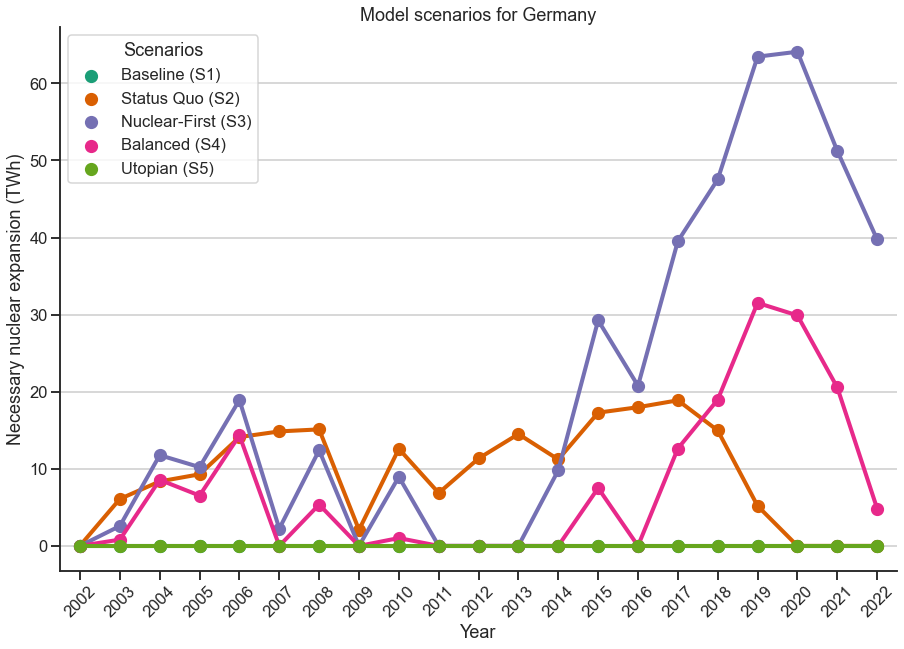

In [246]:
vizualize_models(model=scenarios_germany, country_name='Germany', data_type='deficit')

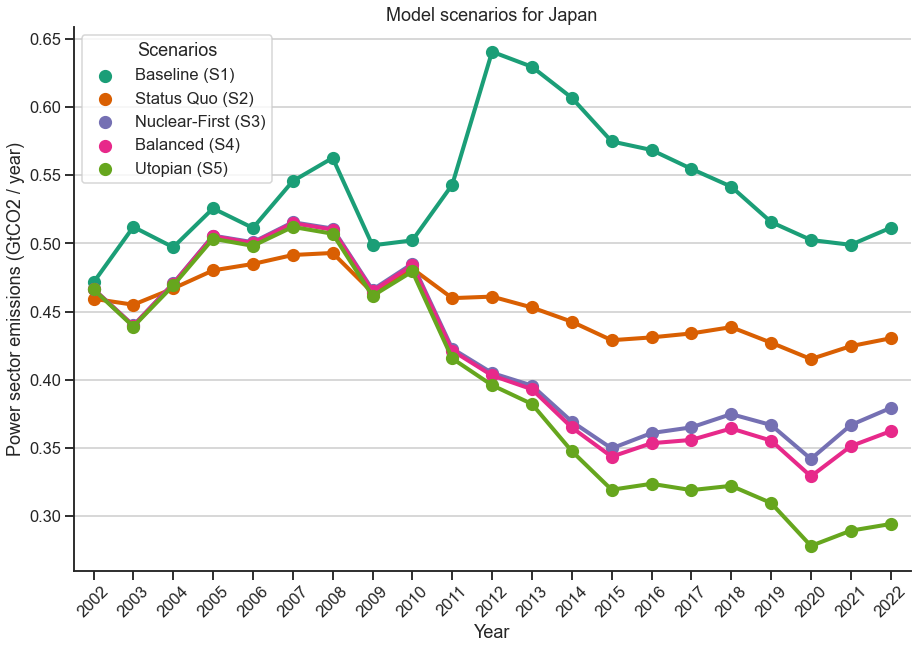

In [241]:
vizualize_models(model=scenarios_japan, country_name='Japan', data_type='emissions')

In [247]:
sum_germany = (
    scenarios_germany.copy()
    .aggregate({'GtCO2_S1':'sum', 'GtCO2_S2':'sum', 'GtCO2_S3':'sum', 'GtCO2_S4':'sum', 'GtCO2_S5':'sum'})
)
sum_germany

GtCO2_S1    5.771173
GtCO2_S2    6.370031
GtCO2_S3    5.744853
GtCO2_S4    5.699643
GtCO2_S5    4.777487
dtype: float64

In [248]:
sum_japan = (
    scenarios_japan.copy()
    .aggregate({'GtCO2_S1':'sum', 'GtCO2_S2':'sum', 'GtCO2_S3':'sum', 'GtCO2_S4':'sum', 'GtCO2_S5':'sum'})
)
sum_japan

GtCO2_S1    11.314742
GtCO2_S2     9.523531
GtCO2_S3     8.860159
GtCO2_S4     8.755010
GtCO2_S5     8.334418
dtype: float64

In [244]:
def vizualize_RES(model, country_name):

    data_viz = model[['Year', 
                      '%_RES_growth_needed'
                     ]]

    data_viz = (
        data_viz.rename(columns={f'%_RES_growth_needed':'Necessary RES growth from S1 (baseline)'
                                })
    )

    sns.set_context("talk")
    sns.set_style("ticks", {'axes.grid' : True})

    plt.figure(figsize=(15,10))

    ax = sns.pointplot(
        data=data_viz, 
        x="Year", 
        y="Necessary RES growth from S1 (baseline)",
        color="Tomato"
    )

    sns.despine()

    plt.ylabel('Share of RES growth from S1 (Baseline) scenario')
    plt.xlabel('Year')
    plt.title(f'Minimum cumulative RES growth from S1 baseline to ensure \nthat nuclear generation replaces fossil generation in {country_name}')

    plt.xticks(rotation=45)
    plt.ylim(-20, 100)

    plt.show()

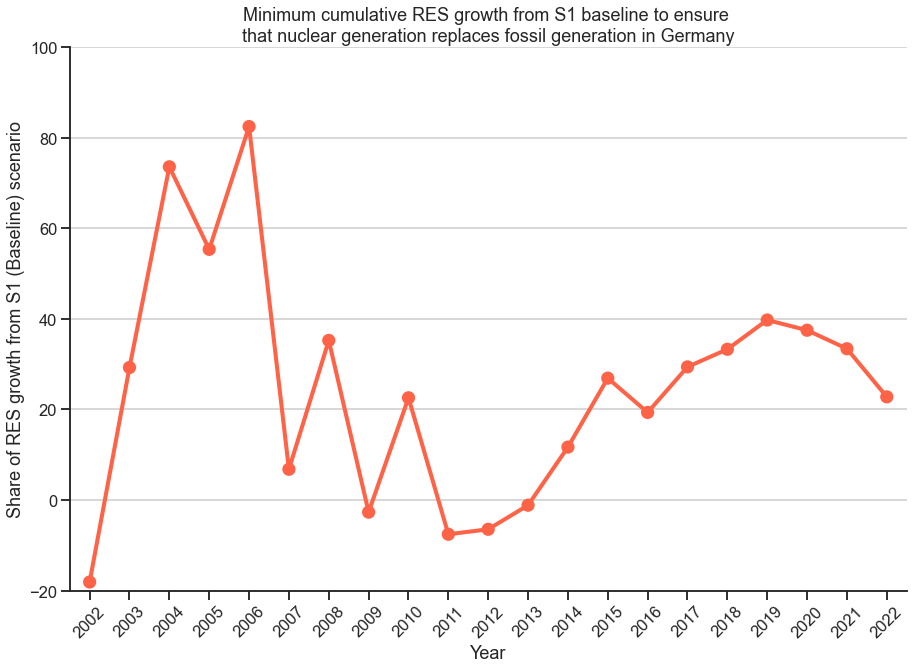

In [245]:
vizualize_RES(model=scenarios_germany, country_name='Germany')